# Metric-based Quantum Architecture Search

## Required imports

In [ ]:
import numpy as np
import scipy

import time
import os

from itertools import combinations, product
from functools import reduce
import copy

import pennylane as qml

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from scipy.stats import spearmanr

# import gym

In [ ]:
!pip install pennylane

## Import and test python files

In [1011]:
from importlib import reload

from create_gate_circs import generate_random_gate_circ, generate_true_random_gate_circ, create_gate_circ, create_batched_gate_circ, get_circ_params
from create_human_design_circs import generate_human_design_circ
from metrics import compute_reduced_similarity
from datasets import load_dataset
import create_noise_models
from create_noise_models import noisy_dev_from_backend

reload(create_noise_models)

<module 'create_noise_models' from '/root/create_noise_models.py'>

In [714]:
num_qubits = 2
num_embeds = 4
num_params = 4

ent_prob = np.random.sample()
cxz = np.random.sample()
pauli = 0

circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, num_params, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                        weights_bounds, [0], 'exp', 'adjoint') 

## Train supercircuit selected circuits

In [ ]:
!python supernet/train_search_bank.py --warmup_epochs 0 --steps 13725 --n_search 1 --n_qubits 4 --n_experts 1 --n_layers 1 --n_encode_layers 2 --save "4_params_mb_2" --data "./experiment_data/bank" --save_dir "./supernet/bank"

2022-08-18 14:50:19.075321: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-08-18 14:50:19.075519: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-08-18 14:50:19.096905: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
(1098, 2, 4) (122, 2, 4)
subnet: [269110], expert_idx: 0
2022-08-18 14:50:30.040427: I tensorflow/core/platform/cpu_feature_guard.cc:142] This Ten

In [ ]:
!python supernet/train_search_bank.py --warmup_epochs 0 --steps 13725 --n_search 1 --n_qubits 4 --n_experts 1 --n_layers 2 --n_encode_layers 2 --save "8_params_mb_2" --data "./experiment_data/bank" --save_dir "./supernet/bank"

In [ ]:
!python supernet/train_search_bank.py --warmup_epochs 0 --steps 13725 --n_search 1 --n_qubits 4 --n_experts 1 --n_layers 3 --n_encode_layers 2 --save "12_params_mb_2" --data "./experiment_data/bank" --save_dir "./supernet/bank"

In [ ]:
!python supernet/train_search_bank.py --warmup_epochs 0 --steps 13725 --n_search 1 --n_qubits 4 --n_experts 1 --n_layers 4 --n_encode_layers 2 --save "16_params_mb_2" --data "./experiment_data/bank" --save_dir "./supernet/bank"

In [ ]:
!python supernet/train_search_fmnist.py --warmup_epochs 0 --steps 50000 --n_search 1 --n_qubits 4 --n_experts 1 --n_layers 6 --n_encode_layers 4 --save "24_params" --data "./experiment_data/fmnist_4/" --save_dir "./supernet/fmnist_4"

2022-09-23 05:10:11.446448: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-09-23 05:10:11.446564: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-09-23 05:10:11.470680: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
(8000, 4, 4) (2000, 4, 4)
subnet: [108438, 68500, 285777, 86028, 124385, 116638], expert_idx: 0
2022-09-23 05:10:23.721226: I tensorflow/core/plat

In [11]:
def convert_supernet_circ_into_gate_circ(subnet, num_embeds, layer_rots, layer_cnots, num_qubits, angle_embed=False):
    circ_gates = []
    gate_params = []
    weights_bounds = [0]
    inputs_bounds = [0]

    curr_layers = subnet
    num_cnots = len(layer_cnots)
    
    for i in range(1):
        num_qubits = len(layer_rots[0])

        if angle_embed:
            rots = ['ry', 'rx', 'rz']
            
            for j in range(num_embeds):
                circ_gates += [rots[j % 3] for i in range(num_qubits)]
                gate_params += [[i] for i in range(num_qubits)]
                weights_bounds += [0 for i in range(num_qubits)]
                inputs_bounds += [inputs_bounds[-1] + i + 1 for i in range(2 * num_qubits - 1)]            
        else:
            for j in range(num_embeds):
                circ_gates += ['h' for i in range(num_qubits)] + ['ry' for i in range(num_qubits)] + ['cry' for i in range(num_qubits - 1)]
                gate_params += [[i] for i in range(num_qubits)] * 2 + [[i, i + 1] for i in range(num_qubits - 1)]
                weights_bounds += [0 for i in range(3 * num_qubits - 1)]
                inputs_bounds += [inputs_bounds[-1] for i in range(num_qubits)] + [inputs_bounds[-1] + i + 1 for i in range(2 * num_qubits - 1)]

        for j in range(len(curr_layers)):
            circ_gates += layer_rots[curr_layers[j] // num_cnots]
            circ_gates += ['cx' for k in layer_cnots[curr_layers[j] % num_cnots]]

            gate_params += [[k] for k in range(len(layer_rots[curr_layers[j] // num_cnots]))]
            gate_params += layer_cnots[curr_layers[j] % num_cnots]

            weights_bounds += [weights_bounds[-1] + k + 1 for k in range(num_qubits)]
            inputs_bounds += [inputs_bounds[-1] for k in range(num_qubits)]

            weights_bounds += [weights_bounds[-1] for k in range(len(layer_cnots[curr_layers[j] % num_cnots]))]
            inputs_bounds += [inputs_bounds[-1] for k in range(len(layer_cnots[curr_layers[j] % num_cnots]))]
            
    return circ_gates, gate_params, inputs_bounds, weights_bounds

In [12]:
from datasets_nt import load_dataset
from create_gate_circs import create_gate_circ
from train_circ import mse_vec_loss, train_qnn
from create_noise_models import noisy_dev_from_backend

import pennylane as qml
import numpy as np
import os

dataset = 'fmnist_4'
main_dir = './supernet/fmnist_4/'

x_train, y_train, x_test, y_test = load_dataset(dataset, 'supernet', 1)

num_qubits = 4
num_cnot_configs = 4096
num_circs = 2500
num_embed_layers = 4
meas_qubits = [0, 1]
num_steps = 16000

dev = qml.device('lightning.qubit', wires=num_qubits)

param_nums = [24]
search_nums = [100]
num_trials = [25]

device_name = 'ibm_nairobi'
noisy_dev = noisy_dev_from_backend(device_name, num_qubits)

for p in param_nums:
    curr_params_dir =  main_dir + 'search-{}_params_mb'.format(p)

    layer_rots = open(curr_params_dir + '/rotations.txt').read().split('\n')[:-1]
    layer_rots = [''.join([j for j in i if j.isupper()]) for i in layer_rots]
    layer_rots = [[i[j * 2:j * 2 + 2].lower() for j in range(len(i) // 2)] for i in layer_rots]

    layer_cnots = open(curr_params_dir + '/cnots.txt').read().split('\n')[:-1]
    layer_cnots = [''.join([j for j in i[1:] if j not in ['[', ']', ',', ' ']]) for i in layer_cnots]
    layer_cnots = [[[int(i[2 * j]), int(i[2 * j + 1])] for j in range(len(i) // 2)] for i in layer_cnots]
        
    circ_accs = np.genfromtxt(curr_params_dir + '/{}/searched_circ_accs.txt'.format(device_name))
    circ_losses = np.genfromtxt(curr_params_dir + '/{}/searched_circ_losses.txt'.format(device_name))
    circ_layers = np.genfromtxt(curr_params_dir + '/{}/searched_circ_layers.txt'.format(device_name)).astype('int32').reshape((num_circs, p // num_qubits))

    for k in range(len(search_nums)):
        search_dir = curr_params_dir + '/{}/search_{}'.format(device_name, search_nums[k])

        if not os.path.exists(search_dir):
            os.mkdir(search_dir)

        for i in range(12, num_trials[k]):
            curr_dir = search_dir + '/trial_{}'.format(i + 1)

            if not os.path.exists(curr_dir):
                os.mkdir(curr_dir)

            chosen_circs = range(search_nums[k] * i, search_nums[k] * i + search_nums[k])
            best_circuit_ind = chosen_circs[np.argmax(circ_accs[chosen_circs])]
            best_subnet = circ_layers[best_circuit_ind]
            print(circ_accs[best_circuit_ind], circ_losses[best_circuit_ind], best_subnet)

            np.savetxt(curr_dir + '/sampled_circuits.txt', circ_layers[chosen_circs])
            np.savetxt(curr_dir + '/sampled_circuit_accs.txt', circ_accs[chosen_circs])

            circ_gates, gate_params, inputs_bounds, weights_bounds = convert_supernet_circ_into_gate_circ(best_subnet, num_embed_layers,
                                                                                                              layer_rots, layer_cnots, num_qubits, False)

            circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                                weights_bounds, meas_qubits, 'exp', 'adjoint') 
            
            noisy_circ = create_gate_circ(noisy_dev, circ_gates, gate_params, inputs_bounds,
                                                                weights_bounds, meas_qubits, 'exp', None)

            losses_list = []
            accs_list = []
            
            noisy_losses_list = []
            noisy_accs_list = []

            for j in range(5):
                curr_train_dir = curr_dir + '/run_{}'.format(j + 1)

                if os.path.exists(curr_train_dir):
                    pass
                else:
                    os.mkdir(curr_train_dir)


                info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], num_steps, 0.05, 1, mse_vec_loss, verbosity=17300, 
                                                                                                    loss_window=50, init_params=None, 
                                                                                                    acc_thres=1.1, shuffle=True, print_loss=50)
                
                np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
                np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

                val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
                val_loss = np.array([mse_vec_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()
                                
                noisy_val_exps = [noisy_circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
                noisy_val_loss = np.array([mse_vec_loss(y_test[k], noisy_val_exps[k]) for k in range(len(x_test))]).flatten()

                acc = np.mean(np.sum(np.multiply(val_exps, y_test) > 0, 1) == 2)
                noisy_acc = np.mean(np.sum(np.multiply(noisy_val_exps, y_test) > 0, 1) == 2)
#                 acc = np.mean(val_loss < 1)
#                 noisy_acc = np.mean(noisy_val_loss < 1)

                losses_list.append(val_loss)
                accs_list.append(acc)
                
                noisy_losses_list.append(noisy_val_loss)
                noisy_accs_list.append(noisy_acc)

            np.savetxt(curr_dir + '/accs.txt', accs_list)
            np.savetxt(curr_dir + '/val_losses.txt', losses_list)          
            
            np.savetxt(curr_dir + '/noisy_accs.txt', noisy_accs_list)
            np.savetxt(curr_dir + '/noisy_val_losses.txt', noisy_losses_list)  

            np.savetxt(curr_dir + '/gates.txt', circ_gates, fmt="%s")
            np.savetxt(curr_dir + '/gate_params.txt', gate_params, fmt="%s")
            np.savetxt(curr_dir + '/inputs_bounds.txt', inputs_bounds)
            np.savetxt(curr_dir + '/weights_bounds.txt', weights_bounds)
            np.savetxt(curr_dir + '/layers.txt', best_subnet)

0.35 2.0014302253723146 [227039 206169   8735  78119  94319  26765]
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-10-13 15:06:47.292 tensorflow-2-6-cpu-py-ml-t3-medium-9169b2e75617c45c79c40579f6a8:2124 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-13 15:06:47.455 tensorflow-2-6-cpu-py-ml-t3-medium-9169b2e75617c45c79c40579f6a8:2124 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Step 1 | Sliding Loss Window : 1.2396321087536386
Step 51 | Sliding Loss Window : 1.3517511881291755
Step 101 | Sliding Loss Window : 1.3934669871700551
Step 151 | Sliding Loss Window : 1.4195684017259216
Step 201 | Sliding Loss Window : 

KeyboardInterrupt: 

In [14]:
from datasets_nt import load_dataset
from create_gate_circs import create_gate_circ
from train_circ import mse_loss, train_qnn
from create_noise_models import noisy_dev_from_backend

dataset = 'fmnist_2'
main_dir = './supernet/fmnist_4/'

x_train, y_train, x_test, y_test = load_dataset(dataset, 'supernet', 1)

num_qubits = 4
num_cnot_configs = 4096
num_circs = 2500
num_embed_layers = 4
meas_qubits = [0, 1]
num_steps = 16000

dev = qml.device('lightning.qubit', wires=num_qubits)

param_nums = [4, 8, 12, 16, 20]
search_nums = [100]
num_trials = [25]

device_name = 'ibm_nairobi'
noisy_dev = noisy_dev_from_backend(device_name, num_qubits)

for p in param_nums:
    curr_params_dir =  main_dir + 'search-{}_params_mb'.format(p)

    layer_rots = open(curr_params_dir + '/rotations.txt').read().split('\n')[:-1]
    layer_rots = [''.join([j for j in i if j.isupper()]) for i in layer_rots]
    layer_rots = [[i[j * 2:j * 2 + 2].lower() for j in range(len(i) // 2)] for i in layer_rots]

    layer_cnots = open(curr_params_dir + '/cnots.txt').read().split('\n')[:-1]
    layer_cnots = [''.join([j for j in i[1:] if j not in ['[', ']', ',', ' ']]) for i in layer_cnots]
    layer_cnots = [[[int(i[2 * j]), int(i[2 * j + 1])] for j in range(len(i) // 2)] for i in layer_cnots]
        
    circ_accs = np.genfromtxt(curr_params_dir + '/{}/searched_circ_accs.txt'.format(device_name))
    circ_losses = np.genfromtxt(curr_params_dir + '/{}/searched_circ_losses.txt'.format(device_name))
    circ_layers = np.genfromtxt(curr_params_dir + '/{}/searched_circ_layers.txt'.format(device_name)).astype('int32').reshape((num_circs, p // num_qubits))
        
#     sampled_circ_list = [j[1:] for j in open(curr_params_dir + '/searched_circ_accs.txt').read().split('\n')[:-1]]
#     circ_accs = [float(j.split(']')[1]) for j in sampled_circ_list]
#     print([j.split(']')[0].strip().split(' ') for j in sampled_circ_list])
#     circ_layers = np.array([[int(k) for k in j.split(']')[0].strip().split(' ') if (k != '')] for j in sampled_circ_list])
    
#     print(circ_accs)
#     print(circ_layers)

    for k in range(len(search_nums)):
#         search_dir = curr_params_dir + '/{}/search_{}'.format(device_name, search_nums[k])
        search_dir = curr_params_dir + '/search_{}'.format(search_nums[k])
        
        if not os.path.exists(search_dir):
            os.mkdir(search_dir)

        for i in range(num_trials[k]):
            curr_dir = search_dir + '/trial_{}'.format(i + 1)

            if not os.path.exists(curr_dir):
                os.mkdir(curr_dir)

            chosen_circs = range(search_nums[k] * i, search_nums[k] * i + search_nums[k])
            best_circuit_ind = chosen_circs[np.argmax(circ_accs[chosen_circs])]
            best_subnet = circ_layers[best_circuit_ind]
            print(circ_accs[best_circuit_ind], best_subnet)

            np.savetxt(curr_dir + '/sampled_circuits.txt', circ_layers[chosen_circs])
            np.savetxt(curr_dir + '/sampled_circuit_accs.txt', circ_accs[chosen_circs])

            circ_gates, gate_params, inputs_bounds, weights_bounds = convert_supernet_circ_into_gate_circ(best_subnet, num_embed_layers,
                                                                                                              layer_rots, layer_cnots, num_qubits, False)

            circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                                weights_bounds, meas_qubits, 'exp', 'adjoint') 
            
#             noisy_circ = create_gate_circ(noisy_dev, circ_gates, gate_params, inputs_bounds,
#                                                                 weights_bounds, meas_qubits, 'exp', None)

            losses_list = []
            accs_list = []
            
#             noisy_losses_list = []
#             noisy_accs_list = []

            for j in range(5):
                curr_train_dir = curr_dir + '/run_{}'.format(j + 1)

                if os.path.exists(curr_train_dir):
                    pass
                else:
                    os.mkdir(curr_train_dir)


                info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], num_steps, 0.05, 1, mse_loss, verbosity=17300, 
                                                                                                    loss_window=50, init_params=None, 
                                                                                                    acc_thres=1.1, shuffle=True, print_loss=50)
                
                np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
                np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

                val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
                val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()
                                
#                 noisy_val_exps = [noisy_circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
#                 noisy_val_loss = np.array([mse_loss(y_test[k], noisy_val_exps[k]) for k in range(len(x_test))]).flatten()

                acc = np.mean(val_loss < 1)
#                 noisy_acc = np.mean(noisy_val_loss < 1)

                losses_list.append(val_loss)
                accs_list.append(acc)
                
#                 noisy_losses_list.append(noisy_val_loss)
#                 noisy_accs_list.append(noisy_acc)

            np.savetxt(curr_dir + '/accs.txt', accs_list)
            np.savetxt(curr_dir + '/val_losses.txt', losses_list)          
            
#             np.savetxt(curr_dir + '/noisy_accs.txt', noisy_accs_list)
#             np.savetxt(curr_dir + '/noisy_val_losses.txt', noisy_losses_list)  

            np.savetxt(curr_dir + '/gates.txt', circ_gates, fmt="%s")
            np.savetxt(curr_dir + '/gate_params.txt', gate_params, fmt="%s")
            np.savetxt(curr_dir + '/inputs_bounds.txt', inputs_bounds)
            np.savetxt(curr_dir + '/weights_bounds.txt', weights_bounds)
            np.savetxt(curr_dir + '/layers.txt', best_subnet)

[['314748'], ['219619'], ['85299'], ['101029'], ['84794'], ['83922'], ['139101'], ['317725'], ['309370'], ['164665'], ['134575'], ['299760'], ['7843'], ['147731'], ['230839'], ['305944'], ['21020'], ['23910'], ['48462'], ['45954'], ['286837'], ['264687'], ['65388'], ['93798'], ['330166'], ['27611'], ['164191'], ['297995'], ['282983'], ['77136'], ['288651'], ['245319'], ['99457'], ['55659'], ['140067'], ['130671'], ['330490'], ['51510'], ['323804'], ['273061'], ['49513'], ['192187'], ['309566'], ['108456'], ['52564'], ['329137'], ['13201'], ['291738'], ['45712'], ['262207'], ['234985'], ['42970'], ['206694'], ['261076'], ['312257'], ['215521'], ['286264'], ['203584'], ['315090'], ['102343'], ['168703'], ['65926'], ['123993'], ['6751'], ['270678'], ['50164'], ['289683'], ['312292'], ['317874'], ['219262'], ['107023'], ['301471'], ['135552'], ['229274'], ['70027'], ['62826'], ['283916'], ['57587'], ['196009'], ['214768'], ['310540'], ['120568'], ['92920'], ['309407'], ['321755'], ['38558'

FileNotFoundError: [Errno 2] No such file or directory: './supernet/mnist_2/search-20_params_mb/searched_circ_accs.txt'

## Train randomly generate circuits

In [ ]:
from datasets import load_dataset

x_train, y_train, x_test, y_test = load_dataset('bank', 'angle', 2)

num_params = [4, 8, 12, 16, 20]

num_qubits = 4
num_embeds = 0

dev = qml.device('lightning.qubit', wires=num_qubits)

for curr_num_params in num_params:
    curr_dir = './random_fe/angle_2/bank/{}_params'.format(curr_num_params)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
        
    for i in range(25):
        curr_circ_dir = curr_dir + '/circ_{}'.format(i + 1)
        
        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, curr_num_params, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
        circ_gates = ['ry'] * 4 + ['rx'] * 4 + circ_gates
        gate_params = [[0], [1], [2], [3]] * 2 + gate_params
        inputs_bounds = [j for j in range(8)] + [8 for i in range(len(inputs_bounds))]
        weights_bounds = [0 for i in range(8)] + weights_bounds
        
        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)
        
        circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                        weights_bounds, [0], 'exp', 'adjoint') 

        losses_list = []
        accs_list = []
        
        for j in range(5):
            curr_train_dir = curr_circ_dir + '/run_{}'.format(j + 1)

            if os.path.exists(curr_train_dir):
                pass
            else:
                os.mkdir(curr_train_dir)
                        
            info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], 5490, 0.05, 1, mse_loss, verbosity=17300, 
                                                                                            loss_window=50, init_params=None, 
                                                                                            acc_thres=1.1, shuffle=True, print_loss=50)

            val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
            val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

            acc = np.mean(val_loss < 1)

            np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
            np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

            losses_list.append(val_loss)
            accs_list.append(acc)

        np.savetxt(curr_circ_dir + '/accs.txt', accs_list)
        np.savetxt(curr_circ_dir + '/val_losses.txt', losses_list)   

/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Step 1 | Sliding Loss Window : 2.0396086163815306
Step 51 | Sliding Loss Window : 1.6825947153669816
Step 101 | Sliding Loss Window : 1.5011569506089522
Step 151 | Sliding Loss Window : 1.7781573962917594
Step 201 | Sliding Loss Window : 1.4185889305169441
Step 251 | Sliding Loss Window : 1.5265055873174236
Step 301 | Sliding Loss Window : 1.0567758463913561
Step 351 | Sliding Loss Window : 1.4710279935281068
Step 401 | Sliding Loss Window : 1.5939285373585454
Step 451 | Sliding Loss Window : 1.4553825717756006
Step 501 | Sliding Loss Window : 1.3921831153767317
Step 551 | Sliding Loss Window : 1.4451471278381947
Step 601 | Sliding Loss Window : 1.7096713812795425
Step 651 | Sliding Loss Window : 1.44509007411521
Step 701 | Sliding Loss Window : 1.5337919813037673
Step 751 | Sliding Loss Window : 1.3320807995648476
Step 801 | Sliding Loss Window : 1.4251928981433668
Step 851 | Sliding Loss Window : 1.5705600835115243
Step 901 | Sliding Loss Window : 1.4341084047664412
Step 951 | Slidin

## Train human designed circuits

In [ ]:
from datasets import load_dataset
from create_human_design_circs import generate_human_design_circ

dataset = 'mnist_2'
num_reps = 1

num_qubits = 4
dev = qml.device('lightning.qubit', wires=num_qubits)
meas_qubits = [0]

ours_dir = './human_design/amp_basic/mnist_2/'

x_train, y_train, x_test, y_test = load_dataset(dataset, 'angle', num_reps)
x_train = x_train.reshape((len(x_train), 1, x_train.shape[1]))
x_test = x_test.reshape((len(x_test), 1, x_test.shape[1]))

num_params = [4, 8, 12, 16, 20]
params_per_layer = 4

num_embed_layers = 1

dev = qml.device('lightning.qubit', wires=num_qubits)

var_layer_options = [[qml.RY], [qml.RX]] * 4
enc_layer_options = [[None, True]]

for curr_num_params in num_params:
    curr_dir = ours_dir + '{}_params'.format(curr_num_params)
    
    if not os.path.exists(curr_dir):
        os.mkdir(curr_dir)
        
    curr_num_layers = curr_num_params // params_per_layer
    curr_weights_shape = (curr_num_layers, 1, num_qubits)
        
    for i in range(1):
        curr_circ_dir = curr_dir

        circ = generate_human_design_circ(dev, num_qubits, 'amp', 'basic', num_embed_layers, curr_num_layers, enc_layer_options,
                                          var_layer_options[:curr_num_layers], meas_qubits, 'exp')
        
        losses_list = []
        accs_list = []
        
        for j in range(5):
            curr_train_dir = curr_circ_dir + '/run_{}'.format(j + 1)

            if os.path.exists(curr_train_dir):
                pass
            else:
                os.mkdir(curr_train_dir)
                        
            info = train_qnn(circ, x_train, y_train, x_test, y_test, curr_weights_shape, 8000, 0.05, 1, mse_loss, verbosity=17300, 
                                                                                            loss_window=50, init_params=None, 
                                                                                            acc_thres=1.1, shuffle=True, print_loss=50)

            val_exps = np.array([circ(x_test[i], info[-1][-1]) for i in range(len(x_test))])
            val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

            acc = np.mean(val_loss < 1)

            shape = np.array(info[-1]).shape
            
            np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), np.array(info[-1]).reshape(shape[0], np.product(shape[1:])))
            np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])

            losses_list.append(val_loss)
            accs_list.append(acc)

        np.savetxt(curr_circ_dir + '/accs.txt', accs_list)
        np.savetxt(curr_circ_dir + '/val_losses.txt', losses_list) 

Step 1 | Sliding Loss Window : 1.3864017789496044
Step 51 | Sliding Loss Window : 1.074629601404598
Step 101 | Sliding Loss Window : 0.882096079030761
Step 151 | Sliding Loss Window : 0.8091304836779972
Step 201 | Sliding Loss Window : 0.8628391431709704
Step 251 | Sliding Loss Window : 0.7691751375256962
Step 301 | Sliding Loss Window : 0.7867960302816681
Step 351 | Sliding Loss Window : 0.6024088426296055
Step 401 | Sliding Loss Window : 0.5574467300491387
Step 451 | Sliding Loss Window : 0.5393929696760125
Step 501 | Sliding Loss Window : 0.5540858265001384
Step 551 | Sliding Loss Window : 0.6260213386533569
Step 601 | Sliding Loss Window : 0.45836416153198556
Step 651 | Sliding Loss Window : 0.6442724859514622
Step 701 | Sliding Loss Window : 0.6736043485831589
Step 751 | Sliding Loss Window : 0.5126694000772793
Step 801 | Sliding Loss Window : 0.6246122121106517
Step 851 | Sliding Loss Window : 0.5510429306028897
Step 901 | Sliding Loss Window : 0.5151820065727628
Step 951 | Slidi

## Search for circuits using our method

In [ ]:
from create_gate_circs import generate_random_gate_circ, generate_true_random_gate_circ, create_gate_circ, create_batched_gate_circ, get_circ_params
from create_human_design_circs import generate_human_design_circ
from metrics import compute_reduced_similarity
from datasets_nt import load_dataset

ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16)), np.zeros((16, 16)), np.zeros((16, 16))))
ideal_2 = np.concatenate((np.zeros((16, 16)), np.ones((16, 16)), np.zeros((16, 16)), np.zeros((16, 16))))
ideal = np.concatenate((ideal, ideal_2, ideal_2[::-1, :], ideal[::-1, :]), 1)

# ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16))))
# ideal = np.concatenate((ideal, ideal[::-1, :]), 1)

dataset = 'mnist_4'

search_params = [24, 28, 32, 36, 40]

num_qubits = 4
num_embeds = 16
meas_qubits = [0, 1]
samples_per_class = 2000

curr_dir = './ours/{}/'.format(dataset)

if not os.path.exists(curr_dir):
    os.mkdir(curr_dir)

x_train, y_train, x_test, y_test = load_dataset(dataset, 'angle', 1)

class_0_sel = np.random.choice(samples_per_class, 16, False)
class_1_sel = np.random.choice(samples_per_class, 16, False) + samples_per_class
class_2_sel = np.random.choice(samples_per_class, 16, False) + (samples_per_class * 2)
class_3_sel = np.random.choice(samples_per_class, 16, False) + (samples_per_class * 3)
sel_inds = np.concatenate((class_0_sel, class_1_sel, class_2_sel, class_3_sel))

# class_0_sel = np.random.choice(samples_per_class, 16, False)
# class_1_sel = np.random.choice(samples_per_class, 16, False) + samples_per_class
# sel_inds = np.concatenate((class_0_sel, class_1_sel))

sel_data = x_train[sel_inds]

num_params = 32
num_data = len(sel_data)

np.savetxt('./ours/{}/sel_data.txt'.format(dataset), sel_data)

dev = qml.device('lightning.qubit', wires=num_qubits)

for p in search_params:
    curr_param_dir = curr_dir + '{}_params'.format(p)
    
    if not os.path.exists(curr_param_dir):
        os.mkdir(curr_param_dir)
    
    d2_min_scores = []
    d2_mean_scores = []
    d2_var_scores = []
    
    d2_t_min_scores = []
    d2_t_mean_scores = []
    d2_t_var_scores = []
    
    mean_mat_scores = []
    mean_t_mat_scores = []

    for i in range(2500):
        curr_circ_dir = curr_param_dir + '/circ_{}'.format(i + 1)

        if not os.path.exists(curr_circ_dir):
            os.mkdir(curr_circ_dir)
        
        ent_prob = np.random.sample()
        cxz = np.random.sample()
        pauli = 0

        params = 2 * np.pi * np.random.sample((num_params, p))
        np.savetxt(curr_circ_dir + '/params.txt', params)
        
        circ_gates, gate_params, inputs_bounds, weights_bounds = generate_true_random_gate_circ(num_qubits, num_embeds, p, 
                                                                                                        ent_prob=ent_prob, 
                                                                                                        cxz_prob=cxz * ent_prob,
                                                                                                        pauli_prob=pauli * (
                                                                                                            1 - cxz) * ent_prob)
        
        np.savetxt(curr_circ_dir + '/gates.txt', circ_gates, fmt="%s")
        np.savetxt(curr_circ_dir + '/gate_params.txt', gate_params, fmt="%s")
        np.savetxt(curr_circ_dir + '/inputs_bounds.txt', inputs_bounds)
        np.savetxt(curr_circ_dir + '/weights_bounds.txt', weights_bounds)

        batched_circ = create_batched_gate_circ(qml.device('lightning.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
                                            weights_bounds, meas_qubits, 'matrix') 

        circ_d2_scores = []
        circ_d2_t_scores = []
        circ_mean_mat = np.zeros((num_data, num_data))
        circ_t_mean_mat = np.zeros((num_data, num_data))

        for j in range(num_params):
            curr_params = np.concatenate([params[j] for k in range(num_data)]).reshape((num_data, p))
            mat = compute_reduced_similarity(batched_circ, curr_params, sel_data)
            
            t_mat = mat > ((np.sum(mat) - num_data) / (num_data * (num_data - 1)))
        
            diff_mat = mat - ideal
            diff_2d = np.sum(np.multiply(diff_mat, diff_mat))

            diff_t_mat = t_mat - ideal
            diff_2d_t = np.sum(np.multiply(diff_t_mat, diff_t_mat))

            circ_d2_scores.append(diff_2d)
            circ_d2_t_scores.append(diff_2d_t)

            circ_mean_mat += mat / num_params
            circ_t_mean_mat += t_mat / num_params
            
        np.savetxt(curr_circ_dir + '/d2_scores.txt', circ_d2_scores)
        np.savetxt(curr_circ_dir + '/d2_t_scores.txt', circ_d2_t_scores)
        
        d2_min_scores.append(np.min(circ_d2_scores))
        d2_mean_scores.append(np.mean(circ_d2_scores))
        d2_var_scores.append(np.var(circ_d2_scores))
        
        d2_t_min_scores.append(np.min(circ_d2_t_scores))
        d2_t_mean_scores.append(np.mean(circ_d2_t_scores))
        d2_t_var_scores.append(np.var(circ_d2_t_scores))
        
        diff_mean_mat = ideal - circ_mean_mat
        diff_t_mean_mat = ideal - circ_t_mean_mat
        
        mean_mat_scores.append(np.sum(np.multiply(diff_mean_mat, diff_mean_mat)))
        mean_t_mat_scores.append(np.sum(np.multiply(diff_t_mean_mat, diff_t_mean_mat)))
        
        print(i)
        
    np.savetxt(curr_param_dir + '/d2_mean_scores.txt', d2_mean_scores)
    np.savetxt(curr_param_dir + '/d2_min_scores.txt', d2_min_scores)
    np.savetxt(curr_param_dir + '/d2_var_scores.txt', d2_var_scores)
    
    np.savetxt(curr_param_dir + '/d2_t_mean_scores.txt', d2_t_mean_scores)
    np.savetxt(curr_param_dir + '/d2_t_min_scores.txt', d2_t_min_scores)
    np.savetxt(curr_param_dir + '/d2_t_var_scores.txt', d2_t_var_scores)
    
    np.savetxt(curr_param_dir + '/d2_mean_mat_scores.txt', mean_mat_scores)
    np.savetxt(curr_param_dir + '/d2_mean_t_mat_scores.txt', mean_t_mat_scores)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [ ]:
!python supernet/train_search_bank.py --warmup_epochs 0 --steps 13725 --n_search 1 --n_qubits 4 --n_experts 1 --n_layers 1 --n_encode_layers 2 --save "4_params_mb_2" --data "./experiment_data/bank" --save_dir "./supernet/bank"

2022-08-16 11:00:02.590720: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2022-08-16 11:00:02.590908: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2022-08-16 11:00:02.612139: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
/usr/local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
(1098, 2, 4) (122, 2, 4)
subnet: [127606], expert_idx: 0
2022-08-16 11:00:13.353077: I tensorflow/core/platform/cpu_feature_guard.cc:142] This Ten

## train our circuir

In [ ]:
from datasets_nt import load_dataset
from create_gate_circs import get_circ_params, create_gate_circ
from train_circ import train_qnn, mse_vec_loss
from create_noise_models import noisy_dev_from_backend

search_nums = [100]
param_nums = [12, 16]

dataset = 'fmnist_4'
num_reps = 1

num_qubits = 4
dev = qml.device('lightning.qubit', wires=num_qubits)
meas_qubits = [0, 1]
mat_size = 4096

device_name = 'ibmq_lima'
noisy_dev = noisy_dev_from_backend(device_name, num_qubits)

ours_dir = './ours/fmnist_4/'

x_train, y_train, x_test, y_test = load_dataset(dataset, 'angle', num_reps)

for search_num in search_nums:       
    for param_num in param_nums:
        noise_scores = []
        
        for i in range(2500):
            noise_scores.append(np.genfromtxt(ours_dir + '/{}_params/circ_{}/noise_metric/{}/metric_tvd_score.txt'.format(param_num, i + 1, device_name)))
            
        noise_scores = np.array(noise_scores)
        
        mean_t_mat_scores = np.genfromtxt(ours_dir + '{}_params/d2_mean_t_mat_scores.txt'.format(param_num))
        perf_scores = (mat_size - mean_t_mat_scores) / mat_size
        combined_scores = np.multiply(perf_scores, noise_scores)
        
        circ_inds = np.random.permutation(2500)
        
        curr_dir = ours_dir + '/{}_params/search_{}_{}'.format(param_num, search_num, device_name)
        
        if not os.path.exists(curr_dir):
            os.mkdir(curr_dir)

        for j in range(25):
            curr_trial_dir = curr_dir + '/trial_{}'.format(j + 1)

            if not os.path.exists(curr_trial_dir):
                os.mkdir(curr_trial_dir)
        
            sel_inds = circ_inds[range(j * 100, j * 100 + 100)]
            sel_ind = sel_inds[np.argmax(combined_scores[sel_inds])]

            np.savetxt(curr_trial_dir + '/searched_circuit_inds.txt', sel_inds)
            np.savetxt(curr_trial_dir + '/searched_circuit_scores.txt', combined_scores[sel_inds])
            np.savetxt(curr_trial_dir + '/sel_circuit_ind.txt', [sel_ind])
            np.savetxt(curr_trial_dir + '/sel_circuit_score.txt', [combined_scores[sel_ind]])
            
            print(sel_inds, combined_scores[sel_inds])
            print(sel_ind, combined_scores[sel_ind])
            print(noise_scores[sel_ind], perf_scores[sel_ind])

            circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(ours_dir + '{}_params/circ_{}'.format(param_num, sel_ind + 1))

            circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                                weights_bounds, meas_qubits, 'exp', 'adjoint')
            
            noisy_circ = create_gate_circ(noisy_dev, circ_gates, gate_params, inputs_bounds,
                                                                weights_bounds, meas_qubits, 'exp', None)
        
            losses_list = []
            accs_list = []
            noisy_losses_list = []
            noisy_accs_list = []

            for j in range(5):
                curr_train_dir = curr_trial_dir + '/run_{}'.format(j + 1)

                if os.path.exists(curr_train_dir):
                    pass
                else:
                    os.mkdir(curr_train_dir)


                info = train_qnn(circ, x_train, y_train, x_test, y_test, [weights_bounds[-1]], 16000, 0.05, 1, mse_vec_loss, verbosity=17300, 
                                                                                                loss_window=50, init_params=None, 
                                                                                                acc_thres=1.1, shuffle=True, print_loss=50)

                val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
                val_loss = np.array([mse_vec_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()
                
                noisy_val_exps = [noisy_circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
                noisy_val_loss = np.array([mse_vec_loss(y_test[k], noisy_val_exps[k]) for k in range(len(x_test))]).flatten()

#                 acc = np.mean(val_loss < 1)
#                 noisy_acc = np.mean(noisy_val_loss < 1)
                acc = np.mean(np.sum(np.multiply(val_exps, y_test) > 0, 1) == 2)
                noisy_acc = np.mean(np.sum(np.multiply(noisy_val_exps, y_test) > 0, 1) == 2)

                np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
                np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])             

                losses_list.append(val_loss)
                accs_list.append(acc)
                
                noisy_losses_list.append(noisy_val_loss)
                noisy_accs_list.append(noisy_acc)

            np.savetxt(curr_trial_dir + '/accs.txt', accs_list)
            np.savetxt(curr_trial_dir + '/val_losses.txt', losses_list)          
            np.savetxt(curr_trial_dir + '/noisy_accs.txt', noisy_accs_list)
            np.savetxt(curr_trial_dir + '/noisy_val_losses.txt', noisy_losses_list) 

[ 231 2425  707   91   48 1265 1115 1183  655 1682  589 1938 2475 1167
  893 1025  540  104 2363 2417  363 2021  845  482 1751  242 1530 1326
 2366  986  488 1748  383  988 1693 1144 2213 1127 1312 2390 1108 1047
 1822  323 1595 2126 1355 1900 2349 2054 1430  282 2419 1626 1881 1691
  331 2024  239 1981 2158 2474 1237   59 1744 1545  457  408 2053  870
 1752 1764 2165 2187 1869 1967  462 1212   14  699  969  452 1372 1745
    9   97  427  527 1533  668  669 2160  642 2344 1155 2331 2302  455
 2402 1817] [0.70082487 0.61597935 0.72991198 0.71101689 0.73534738 0.63624333
 0.61444122 0.7335973  0.63708253 0.54981873 0.70770041 0.64366119
 0.69987307 0.70081298 0.72101972 0.75098106 0.67533486 0.75539688
 0.5599519  0.62813601 0.47705172 0.73275056 0.73991039 0.74783259
 0.71043757 0.68026158 0.60929489 0.65699707 0.71196311 0.73461071
 0.75519175 0.68205411 0.63716662 0.74485585 0.64562666 0.69374367
 0.64901049 0.6966212  0.73985266 0.69153643 0.59170444 0.72851509
 0.73249085 0.65270568

## Compute metrics for all the correlation circuits

In [ ]:
from datasets import TorchDataset, load_dataset
from create_gate_circs_np import get_circ_params, TQCirc, generate_random_gate_circ
from train_circ_np import train_tq_model

import pickle as pkl
import torch
import os
import numpy as np
import shutil

num_qubits = 10

device = torch.device('cpu')

dataset = 'mnist_10'

train_x, train_y, test_x, test_y = load_dataset(dataset, 'angle', 1)

sel_data = train_x[np.random.choice(np.argwhere(train_y == 0).flatten(), 16, False)]

for i in range(1, 10):
    sel_data = np.concatenate((sel_data, train_x[np.random.choice(np.argwhere(train_y == i).flatten(), 16, False)]))

torch.inference_mode(True)

all_mats = []

for i in range(10, 20):
    curr_dir = './experiment_data/{}/trained_circuits/circ_{}'.format(dataset, i + 1)
    
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir) 

    model = TQCirc(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, False).to(device)
    model_params = list(model.parameters())
    random_params = np.random.sample((32, 160)) * 2 * np.pi
    
    overall_mat = torch.zeros((160, 160))
    
    for j in range(32):
        out_states = torch.zeros((160, 1024), dtype=torch.cfloat)
        
        for l in range(160):
            model_params[l].data.fill_(random_params[j, l])    
    
        for l in range(40):
            model(sel_data[4 * l:4 * l + 4])
            out_states[4 * l:4 * l + 4] = torch.reshape(model.device.states, (4, 1024))
            
        print(j)
        
        fid_mat = torch.pow(torch.abs(torch.matmul(out_states, torch.conj(torch.transpose(out_states, 0, 1)))), 2)
        
        overall_mat = torch.add(overall_mat, fid_mat)
        
    overall_mat = torch.divide(overall_mat, 32)
    all_mats.append(overall_mat)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


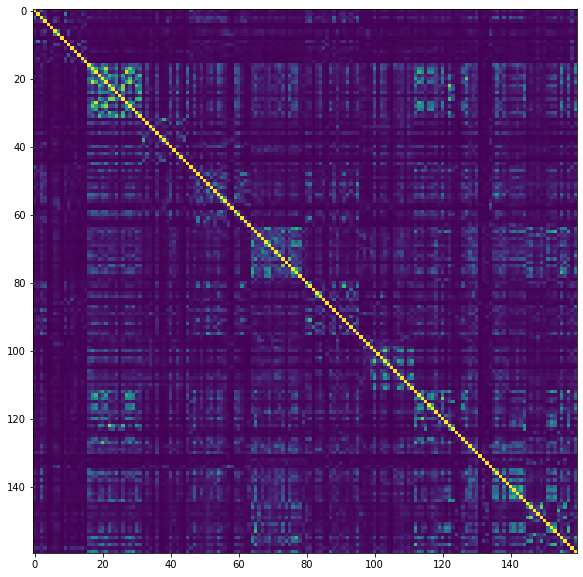

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 2, figsize=(20, 50))

for i in range(10):
    acc = np.genfromtxt('./experiment_data/mnist_10/trained_circuits/circ_{}/run_1/accs.txt'.format(i + 10 + 1))
    
    ax[i // 2, i % 2].imshow(all_mats[i].detach(), vmin=0, vmax=1)
    ax[i // 2, i % 2].set_title(acc)

In [ ]:
from create_gate_circs import generate_random_gate_circ, generate_true_random_gate_circ, create_gate_circ, create_batched_gate_circ, get_circ_params
from create_human_design_circs import generate_human_design_circ
from metrics import compute_reduced_similarity
from datasets_nt import load_dataset

ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16)), np.zeros((16, 16)), np.zeros((16, 16))))
ideal_2 = np.concatenate((np.zeros((16, 16)), np.ones((16, 16)), np.zeros((16, 16)), np.zeros((16, 16))))
ideal = np.concatenate((ideal, ideal_2, ideal_2[::-1, :], ideal[::-1, :]), 1)

# ideal = np.concatenate((np.ones((16, 16)), np.zeros((16, 16))))
# ideal = np.concatenate((ideal, ideal[::-1, :]), 1)

# ideal = 2 * ideal - 1

dataset = 'mnist_4'

curr_dir = f'./experiment_data/{dataset}/trained_circuits'
num_qubits = 4
meas_qubits = [0, 1]
num_samples_per_class = 2000

x_train, y_train, x_test, y_test = load_dataset(dataset, 'angle', 1)

class_0_sel = np.random.choice(num_samples_per_class, 16, False)
class_1_sel = np.random.choice(num_samples_per_class, 16, False) + num_samples_per_class
class_2_sel = np.random.choice(num_samples_per_class, 16, False) + num_samples_per_class * 2
class_3_sel = np.random.choice(num_samples_per_class, 16, False) + num_samples_per_class * 3
sel_inds = np.concatenate((class_0_sel, class_1_sel, class_2_sel, class_3_sel))

# class_0_sel = np.random.choice(len(x_test) // 2, 16, False)
# class_1_sel = np.random.choice(len(x_test) // 2, 16, False) + (len(x_test) // 2)
# sel_inds = np.concatenate((class_0_sel, class_1_sel))

sel_data = x_train[sel_inds]
# sel_data = np.genfromtxt(curr_dir + '/sel_data.txt')

num_params = 32
num_data = len(sel_data)

d2_min_scores = []
d2_mean_scores = []
d2_var_scores = []
    
d2_t_min_scores = []
d2_t_mean_scores = []
d2_t_var_scores = []

mean_mat_scores = []
mean_t_mat_scores = []

np.savetxt(curr_dir + '/sel_data.txt', sel_data)

for i in range(1000):
    circ_dir = curr_dir + '/circ_{}'.format(i + 1)
    
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(circ_dir)
    
    batched_circ = create_batched_gate_circ(qml.device('lightning.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
                                        weights_bounds, meas_qubits, 'matrix') 
    
    params = 2 * np.pi * np.random.sample((num_params, weights_bounds[-1]))
    
    if not os.path.exists(circ_dir + '/fid_mats'):
        os.mkdir(circ_dir + '/fid_mats')
    
    np.savetxt(circ_dir + '/fid_mats/metric_params.txt', params) 
    
    circ_d2_scores = []
    circ_d2_t_scores = []
    circ_mean_mat = np.zeros((num_data, num_data))
    circ_t_mean_mat = np.zeros((num_data, num_data))
    
    for j in range(num_params):
        curr_params = np.concatenate([params[j] for k in range(num_data)]).reshape((num_data, weights_bounds[-1]))
        mat = compute_reduced_similarity(batched_circ, curr_params, sel_data)
        
        t_mat = mat > ((np.sum(mat) - num_data) / (num_data * (num_data - 1)))
        
        diff_mat = mat - ideal
        diff_2d = np.sum(np.multiply(diff_mat, diff_mat))
            
        diff_t_mat = t_mat - ideal
        diff_2d_t = np.sum(np.multiply(diff_t_mat, diff_t_mat))
            
        circ_d2_scores.append(diff_2d)
        circ_d2_t_scores.append(diff_2d_t)
            
        circ_mean_mat += mat / num_params
        circ_t_mean_mat += t_mat / num_params

    np.savetxt(circ_dir + '/fid_mats/d2_scores_2.txt', circ_d2_scores)
    np.savetxt(circ_dir + '/fid_mats/d2_t_scores_2.txt', circ_d2_t_scores)
        
    d2_min_scores.append(np.min(circ_d2_scores))
    d2_mean_scores.append(np.mean(circ_d2_scores))
    d2_var_scores.append(np.var(circ_d2_scores))
        
    d2_t_min_scores.append(np.min(circ_d2_t_scores))
    d2_t_mean_scores.append(np.mean(circ_d2_t_scores))
    d2_t_var_scores.append(np.var(circ_d2_t_scores))
        
    diff_mean_mat = ideal - circ_mean_mat
    diff_t_mean_mat = ideal - circ_t_mean_mat   
    
    mean_mat_scores.append(np.sum(np.multiply(diff_mean_mat, diff_mean_mat)))
    mean_t_mat_scores.append(np.sum(np.multiply(diff_t_mean_mat, diff_t_mean_mat)))
    
    np.savetxt(circ_dir + '/fid_mats/mean_t_mat.txt', circ_t_mean_mat)
    
    print(i)
        
np.savetxt(curr_dir + '/d2_mean_scores_2.txt', d2_mean_scores)
np.savetxt(curr_dir + '/d2_min_scores_2.txt', d2_min_scores)
np.savetxt(curr_dir + '/d2_var_scores_2.txt', d2_var_scores)
    
np.savetxt(curr_dir + '/d2_t_mean_scores_2.txt', d2_t_mean_scores)
np.savetxt(curr_dir + '/d2_t_min_scores_2.txt', d2_t_min_scores)
np.savetxt(curr_dir + '/d2_t_var_scores_2.txt', d2_t_var_scores)
    
np.savetxt(curr_dir + '/d2_mean_mat_scores_kta.txt', mean_mat_scores)
np.savetxt(curr_dir + '/d2_mean_t_mat_scores_kta.txt', mean_t_mat_scores)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## nopise metric for correlation circuits

In [184]:
from importlib import reload

import metrics

reload(metrics)

<module 'metrics' from '/root/metrics.py'>

In [ ]:
from create_noise_models import get_real_backend_dev, noisy_dev_from_backend
from create_gate_circs import create_batched_gate_circ, get_circ_params
from datasets_nt import load_dataset
from metrics import compute_noise_metric

dataset = 'mnist_2'

x_train, y_train, _, __ = load_dataset(dataset, 'angle', 2)

curr_dir = './experiment_data/{}'.format(dataset)

num_qubits = 4
num_trial_params = 128
meas_qubits = [0, 1, 2, 3]

param_nums = [24]

num_cdcs = 128
num_shots = 1024

device_name = 'ibmq_belem'

dev = noisy_dev_from_backend(device_name, num_qubits)
noiseless_dev = qml.device('lightning.qubit', wires=num_qubits)

score_tvds = []
actual_tvds = []

for p in param_nums:
    param_dir = curr_dir + '/trained_circuits'.format(p)
    
    for i in range(1000):
        circ_dir = param_dir + '/circ_{}'.format(i + 1)

        circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(circ_dir)

        noisy_circ = create_batched_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                                    weights_bounds, meas_qubits, 'probs') 

        noiseless_circ = create_batched_gate_circ(noiseless_dev, circ_gates, gate_params, inputs_bounds,
                                                                    weights_bounds, meas_qubits, 'probs') 

        noise_metric_dir = circ_dir + '/noise_metric'

        if not os.path.exists(noise_metric_dir):
            os.mkdir(noise_metric_dir)

        device_noise_metric_dir = noise_metric_dir + '/{}'.format(device_name)

        if not os.path.exists(device_noise_metric_dir):
            os.mkdir(device_noise_metric_dir)

        params = np.random.sample((num_trial_params, weights_bounds[-1])) * 2 * np.pi
        batch_data = x_train[np.random.choice(len(x_train), num_trial_params, False)]

        noiseless_res_raw = np.array(noiseless_circ(batch_data, params, shots=num_shots))
        noisy_res_raw = np.array(noisy_circ(batch_data, params, shots=num_shots))

        actual_tvd = 1 - np.mean(np.sum(0.5 * np.abs(noiseless_res_raw - noisy_res_raw), 1))

        tvd = compute_noise_metric(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, noiseless_dev, dev, num_cdcs=num_cdcs, num_shots=num_shots)

        np.savetxt(device_noise_metric_dir + '/metric_tvd_score.txt', [1 - tvd])
        np.savetxt(device_noise_metric_dir + '/actual_tvd_score.txt', [actual_tvd])

        score_tvds.append(1 - tvd)
        actual_tvds.append(actual_tvd)

        print(1 - tvd, actual_tvd, i)

ibmqfactory.load_account:WARNING:2022-10-24 03:32:32,949: Credentials are already in use. The existing account in the session will be replaced.
/usr/local/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (92038.51932346408 > 2 * 1552.3716846118762). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/usr/local/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (92038.51932346408 > 2 * 1552.3716846118762). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/usr/local/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theor

0.8871002197265625 0.8850555419921875 0
0.9121856689453125 0.9098663330078125 1
0.84857177734375 0.8588485717773438 2
0.8905258178710938 0.8917007446289062 3
0.82147216796875 0.8533859252929688 4
0.8773117065429688 0.8889007568359375 5
0.8994903564453125 0.8934555053710938 6
0.8983688354492188 0.8950424194335938 7
0.9258651733398438 0.925750732421875 8
0.8882598876953125 0.8971939086914062 9
0.6664657592773438 0.6845550537109375 10
0.9126510620117188 0.9110107421875 11
0.8568038940429688 0.8549270629882812 12
0.8127822875976562 0.839019775390625 13
0.8878326416015625 0.8797073364257812 14
0.8633804321289062 0.8626632690429688 15
0.7961883544921875 0.8344955444335938 16
0.8151473999023438 0.8453216552734375 17
0.920501708984375 0.9175491333007812 18
0.8937454223632812 0.8965911865234375 19
0.9094467163085938 0.9023895263671875 20
0.8976516723632812 0.8946075439453125 21
0.9049835205078125 0.9231338500976562 22
0.8700714111328125 0.8772430419921875 23
0.8307342529296875 0.827781677246093

In [39]:
from importlib import reload

import metrics

reload(metrics)

<module 'metrics' from '/root/metrics.py'>

## Train correlatio circuits

In [ ]:
from create_noise_models import noisy_dev_from_backend
from datasets_nt import load_dataset
from create_gate_circs import create_gate_circ, get_circ_params
from train_circ import train_qnn, mse_loss

import numpy as np
import os

dataset = 'mnist_2'

x_train, y_train, x_test, y_test = load_dataset(dataset, 'angle', 2)

num_qubits = 4
num_embeds = 32
num_params = 12

device_name = 'ibmq_belem'

# dev = qml.device('lightning.qubit', wires=num_qubits)
dev = noisy_dev_from_backend(device_name, num_qubits)

for i in range(200):
    curr_dir = './experiment_data/{}/trained_circuits/circ_{}'.format(dataset, i + 1)
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir) 

    circ = create_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                    weights_bounds, [0], 'exp')
    
    
    noiseless_losses = np.genfromtxt(curr_dir + '/val_losses.txt')

    losses_list = []
    accs_list = []
    
    curr_dev_dir = curr_dir + '/' + device_name

#     if not os.path.exists(curr_dev_dir + '/accs_inference_only.txt'):
    if True:
        if not os.path.exists(curr_dev_dir):
            os.mkdir(curr_dev_dir)

        for j in range(5):
            curr_train_dir = curr_dir + '/run_{}'.format(j + 1)
            curr_params = np.genfromtxt(curr_train_dir + '/params_{}.txt'.format(j + 1))[-1]

            val_exps = [circ(x_test[i], curr_params) for i in range(len(x_test))]
            val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

#             acc = np.mean(np.sum(np.multiply(val_exps, y_test) > 0, 1) == 2)
            acc = np.mean(val_loss < 1)

            losses_list.append(val_loss)
            accs_list.append(acc)

        print(np.mean(noiseless_losses), np.mean(losses_list), i + 1)

        np.save(curr_dev_dir + '/val_losses_inference_only.npy', losses_list)
        np.savetxt(curr_dev_dir + '/accs_inference_only.txt', accs_list)
    else:
        print(i)

ibmqfactory.load_account:WARNING:2022-10-21 17:30:09,427: Credentials are already in use. The existing account in the session will be replaced.
/usr/local/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (116978.03068342054 > 2 * 52062.3693340039). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/usr/local/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (92038.51932346408 > 2 * 1552.3716846118762). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/usr/local/lib/python3.8/site-packages/qiskit_aer/noise/device/models.py:365: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theore

0.5700597719844201 0.6370169067382813 1
0.6945461913208423 0.7172812976837158 2


In [14]:
from create_noise_models import noisy_dev_from_backend
from datasets_nt import load_dataset
from create_human_design_circs import generate_human_design_circ
from train_circ import train_qnn, mse_loss

import numpy as np
import os

dataset = 'mnist_2'

num_qubits = 4
num_embeds = 16

meas_qubits = [0]

device_name = 'ibm_nairobi'

# dev = qml.device('lightning.qubit', wires=num_qubits)
dev = noisy_dev_from_backend(device_name, num_qubits)

param_nums = [4, 8, 12, 16, 20]

num_embed_layers = [4, 4, 1]
repetitions = [1, 1, 1]

enc_layer_options = [[['X'], ['Y']] * 2, [[1, None], [1, None]] * 2, [[None, True], [None, True]]]
var_layer_options = [[[qml.RX], [qml.RY]] * 4, [[qml.RX], [qml.RY]] * 4, [[qml.RX], [qml.RY]] * 4]
encoding_types = ['angle',  'iqp', 'amp']

for ec in range(len(encoding_types)):
    x_train, y_train, x_test, y_test = load_dataset(dataset, 'angle', repetitions[ec])
    
    x_train = x_train.reshape((len(x_train), num_embed_layers[ec], -1))
    x_test = x_test.reshape((len(x_test), num_embed_layers[ec], -1))
    
    main_dir = './human_design/{}_basic/mnist_2'.format(encoding_types[ec])
    
    for p in param_nums:
        curr_weights_shape = (p // num_qubits, 1, num_qubits)
        
        curr_dir = main_dir + '/{}_params'.format(p)
                     
        circ = generate_human_design_circ(dev, num_qubits, encoding_types[ec], 'basic', num_embed_layers[ec], p // num_qubits, enc_layer_options[ec],
                                          var_layer_options[ec][:p // num_qubits], meas_qubits, 'exp')

        noiseless_losses = np.genfromtxt(curr_dir + '/val_losses.txt')

        losses_list = []
        accs_list = []

        curr_dev_dir = curr_dir + '/' + device_name

        if not os.path.exists(curr_dev_dir):
            os.mkdir(curr_dev_dir)

        for j in range(5):
            curr_train_dir = curr_dir + '/run_{}'.format(j + 1)
            curr_params = (np.genfromtxt(curr_train_dir + '/params_{}.txt'.format(j + 1))[-1]).reshape(curr_weights_shape)

            val_exps = [circ(x_test[i], curr_params) for i in range(len(x_test))]
            val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()
        
    #             acc = np.mean(np.sum(np.multiply(val_exps, y_test) > 0, 1) == 2)
            acc = np.mean(val_loss < 1)

            losses_list.append(val_loss)
            accs_list.append(acc)

        print(np.mean(noiseless_losses), np.mean(losses_list))

        np.save(curr_dev_dir + '/val_losses_inference_only.npy', losses_list)
        np.savetxt(curr_dev_dir + '/accs_inference_only.txt', accs_list)

ibmqfactory.load_account:WARNING:2022-09-19 08:57:50,767: Credentials are already in use. The existing account in the session will be replaced.


0.8111063215357499 0.8138302917480469
0.4729824537749028 0.5007007865905762
0.27143875214908886 0.3152598743438721
0.27138508784778864 0.32499820518493655
0.21348001145415085 0.27252308654785157
0.9946072554517877 0.9934720134735108
0.822643930674137 0.7898217620849609
0.7308705133428212 0.7251627635955811
0.738905850647093 0.751434118270874
0.7198257218072618 0.7319662780761719
0.5941922056080466 0.8947411022186279
0.26794174680529276 0.6098385391235351
0.21063736525835425 0.9990274982452393
0.18421056150835532 1.0468268508911134
0.14933250939415632 1.0388361625671387


In [25]:
from datasets import load_dataset
from create_gate_circs import create_gate_circ
from train_circ import train_qnn, mse_loss

dataset = 'moons_300'

x_train, y_train, x_test, y_test = load_dataset(dataset, 'angle', 2)

num_qubits = 2
num_embeds = 4
num_params = 8

for i in range(166):
    curr_dir = './experiment_data/moons_300/trained_circuits/circ_{}'.format(i + 1)
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir) 

    circ = create_gate_circ(qml.device('lightning.qubit', wires=num_qubits), circ_gates, gate_params, inputs_bounds,
                                                    weights_bounds, [0], 'exp')    

    losses_list = []
    accs_list = []
    
    for j in range(5):
        curr_train_dir = curr_dir + '/run_{}'.format(j + 1)

        if os.path.exists(curr_train_dir):
            pass
        else:
            os.mkdir(curr_train_dir)
    
        
        info = train_qnn(circ, x_train, y_train, x_test, y_test, [num_params], 2400, 0.05, 1, mse_loss, verbosity=7300, 
                                                                                        loss_window=50, init_params=None, 
                                                                                        acc_thres=1.1, shuffle=True, print_loss=50)
        
        val_exps = [circ(x_test[i], info[-1][-1]) for i in range(len(x_test))]
        val_loss = np.array([mse_loss(y_test[k], val_exps[k]) for k in range(len(x_test))]).flatten()

        acc = np.mean(val_loss < 1)
        
        np.savetxt(curr_train_dir + '/params_{}.txt'.format(j + 1), info[-1])
        np.savetxt(curr_train_dir + '/losses_{}.txt'.format(j + 1), info[0])
        
        losses_list.append(val_loss)
        accs_list.append(acc)
        
    np.savetxt(curr_dir + '/val_losses.txt', losses_list)
    np.savetxt(curr_dir + '/accs.txt', accs_list)

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-09-10 07:16:08.081 tensorflow-2-6-cpu-p-ml-c5-2xlarge-f81bb7fa8e3a8f07f65406d550c8:12747 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-09-10 07:16:08.195 tensorflow-2-6-cpu-p-ml-c5-2xlarge-f81bb7fa8e3a8f07f65406d550c8:12747 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Step 1 | Sliding Loss Window : 0.8471232375917244
Step 51 | Sliding Loss Window : 0.9246482786318824
Step 101 | Sliding Loss Window : 0.6092511104351385
Step 151 | Sliding Loss Window : 0.8308950550525216
Step 201 | Sliding Loss Window : 0.7985505834728335
Step 251 | Sliding Loss Window : 0.770598503381

KeyboardInterrupt: 

In [37]:
from importlib import reload

import datasets
import create_gate_circs
import train_circ

reload(datasets)
reload(create_gate_circs)
reload(train_circ)

<module 'train_circ' from '/root/train_circ.py'>

In [ ]:
from datasets import TorchDataset
from create_gate_circs_np import get_circ_params, TQCirc, generate_random_gate_circ
from train_circ import train_tq_model

import pickle as pkl
import torch
import os
import numpy as np

num_qubits = 10

device = torch.device('cpu')

dataset = 'mnist_10'

train_data = TorchDataset(dataset, 'angle', 1, True)
test_data = TorchDataset(dataset, 'angle', 1, False)

train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, sampler=torch.utils.data.RandomSampler(train_data))
test_data_loader = torch.utils.data.DataLoader(train_data, batch_size=1, sampler=torch.utils.data.RandomSampler(train_data))

val_test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=100, sampler=torch.utils.data.SequentialSampler(test_data))

loss = torch.nn.functional.nll_loss
val_loss = torch.nn.NLLLoss(reduction='none')

for i in range(493, 496):
    curr_dir = './experiment_data/{}/trained_circuits/circ_{}'.format(dataset, i + 1)

    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir) 

    model = TQCirc(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, True).to(device)
    opt = torch.optim.SGD(model.parameters(), lr=0.05)
    
    losses_list = []
    accs_list = []
    
    for j in range(1):
        curr_train_dir = curr_dir + '/run_{}'.format(j + 1)

        if os.path.exists(curr_train_dir):
            pass
        else:
            os.mkdir(curr_train_dir)
    
        accs_history = train_tq_model(model, opt, loss, train_data_loader, test_data_loader, 120000, 1000, 1000)
        
    torch.save(model.state_dict(), curr_dir + '/model.pt')

Step 1 | Accuracy: 0.0
Step 1001 | Accuracy: 1.0
Step 2001 | Accuracy: 0.0
Step 3001 | Accuracy: 1.0
Step 4001 | Accuracy: 0.0
Step 5001 | Accuracy: 0.0
Step 6001 | Accuracy: 0.0
Step 7001 | Accuracy: 0.0
Step 8001 | Accuracy: 1.0
Step 9001 | Accuracy: 0.0
Step 10001 | Accuracy: 1.0
Step 11001 | Accuracy: 1.0
Step 12001 | Accuracy: 0.0
Step 13001 | Accuracy: 0.0
Step 14001 | Accuracy: 1.0
Step 15001 | Accuracy: 0.0
Step 16001 | Accuracy: 0.0
Step 17001 | Accuracy: 0.0
Step 18001 | Accuracy: 1.0
Step 19001 | Accuracy: 0.0
Step 20001 | Accuracy: 0.0
Step 21001 | Accuracy: 1.0
Step 22001 | Accuracy: 0.0
Step 23001 | Accuracy: 0.0
Step 24001 | Accuracy: 1.0
Step 25001 | Accuracy: 0.0
Step 26001 | Accuracy: 0.0
Step 27001 | Accuracy: 0.0
Step 28001 | Accuracy: 0.0
Step 29001 | Accuracy: 0.0
Step 30001 | Accuracy: 1.0
Step 31001 | Accuracy: 1.0
Step 32001 | Accuracy: 0.0
Step 33001 | Accuracy: 1.0
Step 34001 | Accuracy: 1.0
Step 35001 | Accuracy: 0.0
Step 36001 | Accuracy: 1.0
Step 37001 | A

## Add noise models

In [ ]:
from create_noise_models import get_real_backend_dev, noisy_dev_from_backend
from create_gate_circs import create_batched_gate_circ, get_circ_params
from datasets import load_dataset
from metrics import compute_noise_metric

curr_dir = './experiment_data/noise_metric'

num_qubits = 4
num_shots = 1024
num_trial_params = 128
meas_qubits = [0, 1, 2, 3]

num_cdcs = 64
num_shots = 1024

device_name = 'ibmq_lima'

dev = noisy_dev_from_backend(device_name, num_qubits)
noiseless_dev = qml.device('lightning.qubit', wires=num_qubits)

fids = []
noisy_fids = []

for i in range(1000):
    circ_dir = curr_dir + '/circ_{}'.format(i + 1)
    
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(circ_dir)

    noisy_circ = create_batched_gate_circ(dev, circ_gates, gate_params, inputs_bounds,
                                                                weights_bounds, meas_qubits, 'sample') 

    noiseless_circ = create_batched_gate_circ(noiseless_dev, circ_gates, gate_params, inputs_bounds,
                                                                weights_bounds, meas_qubits, 'sample') 
    
    noise_metric_dir = circ_dir + '/noise_metric'
    
    if not os.path.exists(noise_metric_dir):
        os.mkdir(noise_metric_dir)
    
    device_noise_metric_dir = noise_metric_dir + '/{}'.format(device_name)

    if not os.path.exists(device_noise_metric_dir):
        os.mkdir(device_noise_metric_dir)
    
    params = np.random.sample((num_trial_params, weights_bounds[-1]))
    
    np.savetxt(device_noise_metric_dir + '/sel_params.txt', params)
    
    data_list = [[] for i in range(num_trial_params)]
    
    batch_data = np.array(data_list)
    
    noiseless_res_raw = noiseless_circ(batch_data, params, shots=num_shots)
    noisy_res_raw = noisy_circ(batch_data, params, shots=num_shots)

    noiseless_res = [np.unique(noiseless_res_raw[j], return_counts=True, axis=0) for j in range(len(noiseless_res_raw))]
    noisy_res = [np.unique(noisy_res_raw[j], return_counts=True, axis=0) for j in range(len(noisy_res_raw))]
    
    noiseless_meas = [noiseless_res[j][0] for j in range(len(noiseless_res))]
    noisy_meas = [noisy_res[j][0] for j in range(len(noisy_res))]
    
    noiseless_counts = [noiseless_res[j][1].flatten() for j in range(len(noiseless_res))]
    noisy_counts = [noisy_res[j][1].flatten() for j in range(len(noisy_res))]
    
    f = open(device_noise_metric_dir + '/noisy_meas.txt', 'w')
    
    for k in range(len(noisy_meas)):
        f.write(' '.join([''.join([str(g) for g in l]) for l in list(noisy_meas[k])]))
        f.write('\n')
    
    f.close()

    f = open(device_noise_metric_dir + '/noiseless_meas.txt', 'w')
    
    for k in range(len(noiseless_meas)):
        f.write(' '.join([''.join([str(g) for g in l]) for l in list(noiseless_meas[k])]))
        f.write('\n')

    f.close()
    
    f = open(device_noise_metric_dir + '/noisy_counts.txt', 'w')
    
    for k in range(len(noisy_meas)):
        f.write(' '.join([str(l) for l in list(noisy_counts[k])]))
        f.write('\n')

    f.close()
    
    f = open(device_noise_metric_dir + '/noiseless_counts.txt', 'w')
    
    for k in range(len(noiseless_meas)):
        f.write(' '.join([str(l) for l in list(noiseless_counts[k])]))
        f.write('\n')

    f.close()
    
    circ_fids = []
    
    for l in range(num_trial_params):
        noiseless_meas, noiseless_counts = np.unique(noiseless_res_raw[l], return_counts=True, axis=0)
        noisy_meas, noisy_counts = np.unique(noisy_res_raw[l], return_counts=True, axis=0)
        
        all_meas = dict()

        for j in range(len(noiseless_meas)):
            all_meas[''.join([str(k) for k in noiseless_meas[j]])] = -1 * noiseless_counts[j]

        for j in range(len(noisy_meas)):
            try:
                all_meas[''.join([str(k) for k in noisy_meas[j]])] *= -1 * noisy_counts[j]
            except:
                pass

        curr_fid = np.sum(np.sqrt([all_meas[j] for j in all_meas.keys() if all_meas[j] > 0])) / num_shots
        circ_fids.append(curr_fid)
    
    fid = compute_noise_metric(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, noiseless_dev, dev, num_cdcs=num_cdcs, num_shots=num_shots)
    
    np.savetxt(device_noise_metric_dir + '/noise_score.txt', [fid])
    np.savetxt(device_noise_metric_dir + '/noisy_fid_scores.txt', circ_fids)
    np.savetxt(device_noise_metric_dir + '/noisy_fid.txt', [np.mean(circ_fids)])
    
    fids.append(fid)
    noisy_fids.append(np.mean(circ_fids))
    
    print(i)

np.savetxt(curr_dir + '/noise_scores.txt', fids)
np.savetxt(curr_dir + '/noisy_fids.txt', noisy_fids)

ibmqfactory.load_account:WARNING:2022-08-15 10:27:34,923: Credentials are already in use. The existing account in the session will be replaced.
/usr/local/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (196952.9698605516 > 2 * 83381.75326476495). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/usr/local/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (196952.9698605516 > 2 * 83381.75326476495). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/usr/local/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [7]:
import os
import numpy as np

from importlib import reload

import datasets
import create_gate_circs_np
import train_circ_np

reload(datasets)
reload(create_gate_circs_np)
reload(train_circ_np)

<module 'train_circ_np' from '/root/train_circ_np.py'>

In [15]:
main_dir = './experiment_data/mnist_10/trained_circuits'

inds = []

for i in range(300):
    circ_dir = main_dir + '/circ_{}'.format(i + 1)
    
    if os.path.exists(circ_dir + '/accs.txt'):
#         if np.mean(np.genfromtxt(circ_dir + '/accs.txt')) > 0.0001 and not os.path.exists(circ_dir + '/accs_computed.txt'):
        if np.mean(np.genfromtxt(circ_dir + '/accs.txt')) < 1:
            inds.append(i)
            print(i)
inds

106
120


[106, 120]

In [16]:
from datasets import TorchDataset, load_dataset
from create_gate_circs_np import get_circ_params, TQCirc, generate_random_gate_circ
from train_circ_np import train_tq_model

import pickle as pkl
import torch

num_qubits = 10

device = torch.device('cpu')

dataset = 'mnist_10'

train_x, train_y, test_x, test_y = load_dataset(dataset, 'angle', 1)

test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

loss = torch.nn.functional.nll_loss
val_loss = torch.nn.NLLLoss(reduction='none')

torch.inference_mode(True)

for i in inds:
    curr_dir = './experiment_data/{}/trained_circuits/circ_{}'.format(dataset, i + 1)
    
#     if os.path.exists(curr_dir + '/accs_computed.txt'):
#         continue
    
    circ_gates, gate_params, inputs_bounds, weights_bounds = get_circ_params(curr_dir) 

    model = TQCirc(circ_gates, gate_params, inputs_bounds, weights_bounds, num_qubits, True).to(device)
    
    model_data = torch.load(curr_dir + '/model.pt')
    
    model_params = list(model.parameters())

    for l in range(100):
        model_params[l].data.fill_(model_data['var_gates.{}.params'.format(l)].flatten().item())

    curr_val_losses = []
    curr_acc = 0
        
    for k in range(100):
        val_x, val_y = test_x[100 * k:(100 * k + 100)], test_y[100 * k:(100 * k + 100)]
        
        val_preds = model(val_x)
        curr_val_losses.append(val_loss(val_preds, val_y.to(torch.long)).detach().numpy().flatten())
        
        val_class = torch.argmax(val_preds.detach(), 1).detach().numpy().flatten()
        
        curr_acc += np.sum(val_class == val_y.detach().numpy().flatten().astype('int32'))
        
    print(i + 1, curr_acc / 10000)

    np.save(curr_dir + '/val_losses.npy', curr_val_losses)
    np.savetxt(curr_dir + '/accs.txt', [curr_acc])
    np.savetxt(curr_dir + '/accs_computed.txt', [1])

107 0.2768
121 0.3349
